In [4]:

from __future__ import print_function
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image
import imgaug.augmenters as iaa

import torch
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

SyntaxError: from __future__ imports must occur at the beginning of the file (<ipython-input-4-29561516dc5a>, line 5)

In [2]:
torch.cuda.empty_cache()
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)
device = 'cuda'
num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [3]:
init_mAP = 0

weight_folder = "./weights_fasterrcnn"
mAP_weight = "fasterrcnn_resnet50_fpn_mAP.pt"
min_loss_weight = "fasterrcnn_resnet50_fpn_minloss.pt"

if os.path.exists(os.path.join(weight_folder, mAP_weight)):
    print("Load Pre-trained mAP")
    mAP_checkpoint = torch.load(os.path.join(weight_folder, mAP_weight))
    init_mAP = mAP_checkpoint["mAP"]

    
    print("mAP Weight Info: epoch {} , loss {:.3f}, mAP {:.3f} ".format(mAP_checkpoint["epoch"],
                                                                        mAP_checkpoint["loss"],
                                                                        mAP_checkpoint["mAP"]))

if os.path.exists(os.path.join(weight_folder, min_loss_weight)):
    print("Load Pre-trained minloss")
    minloss_checkpoint = torch.load(os.path.join(weight_folder, min_loss_weight))
    init_epoch = minloss_checkpoint["epoch"]
    init_loss = minloss_checkpoint["loss"]
    model.load_state_dict(minloss_checkpoint["model_state_dict"])
    
    print("minloss Weight Info: epoch {} , loss {:.3f}, mAP {:.3f} ".format(minloss_checkpoint["epoch"],
                                                                            minloss_checkpoint["loss"],
                                                                            minloss_checkpoint["mAP"]))

version_minloss = "epoch_{}_loss_{:.3f}_mAP_{:.3f}".format(minloss_checkpoint["epoch"],
                                                            minloss_checkpoint["loss"],
                                                            minloss_checkpoint["mAP"])

version_mAP = "epoch_{}_loss_{:.3f}_mAP_{:.3f}".format(mAP_checkpoint["epoch"],
                                                        mAP_checkpoint["loss"],
                                                        mAP_checkpoint["mAP"])

Load Pre-trained mAP
mAP Weight Info: epoch 100 , loss 0.531, mAP 2.615 
Load Pre-trained minloss
minloss Weight Info: epoch 81 , loss 0.531, mAP 2.619 


In [4]:
from tqdm import tqdm
def format_prediction_string(boxes, scores):
    pred_strings = []
    for s, b in zip(scores, boxes.astype(int)):
        
        if not ((b[2]) > 1023 or (b[3]) > 1023):

            pred_strings.append(f'{s:.4f} {b[0]} {b[1]} {b[2] - b[0]} {b[3] - b[1]}')
        if ((b[2]) > 1023 or (b[3]) > 1023):
            print(b[2], b[3])

    return " ".join(pred_strings)

def format_prediction_string2(boxes, scores):
    pred_strings = ""
    for s, b in zip(score, boxes):
        if not ((b[2]) > 1023 or (b[2]) > 1023):
            if ((b[2]) > 1023 or (b[2]) > 1023):
                print(b[2], b[3])
            pred_strings += "{:.4f} {} {} {} {} ".format(s, b[0], b[1], b[2]-b[0], b[3]-b[1])
    return pred_strings

In [5]:
DIR_INPUT = './data'
DIR_TRAIN = f'{DIR_INPUT}/train'

DIR_TEST = f'{DIR_INPUT}/test'
test_csv = pd.read_csv(os.path.join(DIR_INPUT, "sample_submission.csv"))

model.cuda()
model.eval()


detection_threshold = 0.5
results = []


def compare2string(str1, str2):
    result1 = ''
    result2 = ''

    #handle the case where one string is longer than the other
    maxlen=len(str2) if len(str1)<len(str2) else len(str1)
    print(len(str1), len(str2))
    #loop through the characters
    for i in range(maxlen):
        #use a slice rather than index in case one string longer than other
        letter1=str1[i:i+1]
        letter2=str2[i:i+1]
        #create string with differences
        if letter1 != letter2:
            result1+=letter1
            result2+=letter2
            print(letter1, letter2)


for idx, row in tqdm(test_csv.iterrows(), total=len(test_csv)):
    img_path = os.path.join(DIR_TEST, row.image_id+".jpg")
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img = img/255.0
    
    test_img = transforms.functional.to_tensor(img.copy()).unsqueeze(0).to(device)
    outputs = model(test_img)
    boxes = outputs[0]['boxes'].data.cpu().numpy()
    scores = outputs[0]['scores'].data.cpu().numpy()
    
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]
    
    img_id = row.image_id
#     print(format_prediction_string(boxes[:5], scores[:5]))

    result = {
        'image_id': img_id,
        'PredictionString': format_prediction_string(boxes, scores)
    }
    results.append(result)

100%|██████████| 10/10 [00:01<00:00,  5.24it/s]

1024 1016


In [6]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
for ss in test_df["PredictionString"]:
    ss = ss.split(" ")
    for i in range(int(len(ss)/5)):
        boxes = ss[i*5: i*5+5]
        
        conf = boxes[0]
        x, y, w, h = np.array(boxes[1:], dtype = np.int32)
        
        if (x+w) > 1023 or (y+h) > 1023:
            print(boxes)
            print((x+w) , (y+h))

In [7]:
print(version_minloss)
test_df.to_csv("./submission/" + "submission_{}.csv".format(version_minloss), index=False)

epoch_81_loss_0.531_mAP_2.619


## Plot test images

In [8]:
test_df = pd.read_csv("./submission/" + "submission_{}.csv".format(version_minloss))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


105
85


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


125
65


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


120


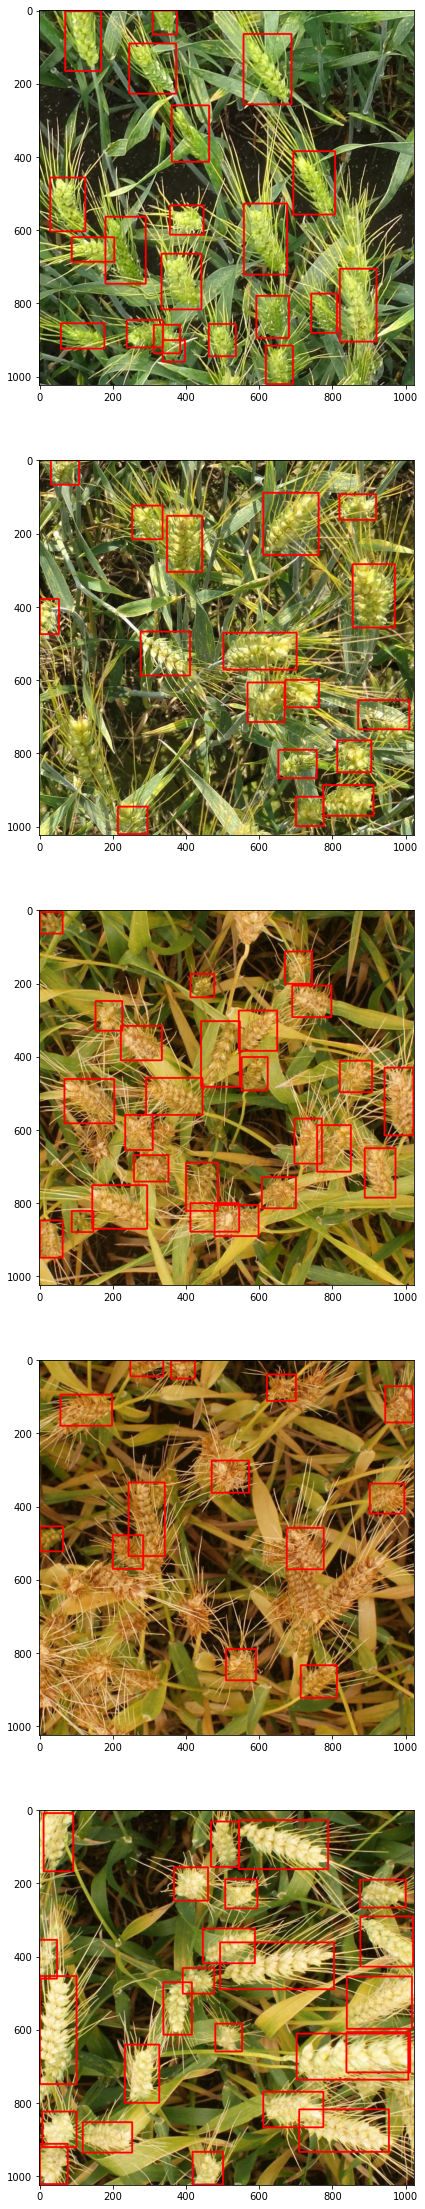

In [9]:
fig, axes = plt.subplots(5, 1, figsize=(100, 40))
for i in range(5):
    img_path = os.path.join(DIR_TEST, test_df.loc[i,"image_id"]+".jpg")
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    img = img/255.0
    preds = test_df.loc[i, "PredictionString"].split(" ")
    print(len(preds))
#     preds = preds[:-1]
    preds = np.array(preds).reshape(int(len(preds)/5), 5)
    
    for pred in preds:
        sample = cv2.rectangle(img,
                              (int(pred[1]), int(pred[2])),
                              (int(pred[1]) + int(pred[3]), int(pred[2]) + int(pred[4])),
                              (220, 0, 0), 3)
    
    axes[i].imshow(sample)
plt.show()